In [31]:
import netCDF4
import operator
import xarray as xr
import dask
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import scipy
from scipy import signal
import math
from mpl_toolkits.basemap import Basemap
bm = Basemap() 

#added from Lutsko Github
import spectrum 

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [32]:
#Good_July.nc
path_to_file = '/fast/gmooers/Preprocessed_Data/CAM_July.nc'
real_ds = xr.open_dataset(path_to_file)


print('files imported')

files imported


In [33]:
#heat_real_ds = real_ds.PTEQ[:, :].values
heat_real_ds = real_ds.PTEQ[:, :30].values
print(heat_real_ds.shape)
times = real_ds.time.values

lats = real_ds.lat.values

lons = real_ds.lon.values

(2976, 30, 96, 144)


In [35]:
x = 144
y = 96
z = 30
t = int(len(heat_real_ds)/(x*y))

In [36]:

spacing = 1/96

reconstructed_targets = heat_real_ds

In [37]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
plev = np.array(others.variables['lev'])
ps = np.array(others.variables['PS'])
g = 9.81 #m/s^2
L = 2256000.0
cp = 1004.0
#print(plev)
hyai = np.array(others.variables['hyai'])
hybi = np.array(others.variables['hybi'])
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
dp = P[1:]-P[:-1] # Differential pressure [Pa]
#convert from k/s to w/m^2
#pressure_weighted_targets = reconstructed_targets*dp[None, :,None, None]*cp/g
pressure_weighted_targets = reconstructed_targets*dp[None, :,None, None]*L/g
print('made it')

made it


In [38]:
def spectrum_gen(h, dt):
    nt = len(h)
    #Get half the length of the time series to avoid redudant information
    npositive = nt//2
    pslice = slice(1, npositive)
    #Get frequencies
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    #perform the fft 
    ft = np.fft.fft(h)[pslice]
    #remove imaginary componant of the fft and square
    psraw = np.conjugate(ft) *ft
    #double to account for the negative half that was removed above
    psraw *= 2.0
    #Normalization for the power spectrum
    psraw /= nt**2
    #Go fro mthe Power Spectrum to Power Density
    psdraw = psraw * dt * nt
    return freqs, psraw, psdraw
    
#spectrum_gen(s1, t[1]-t[0])

In [39]:
def spectrum_generator(targets, levels, latitude_count, longitude_count, time_space):
    targ_freqs, targ_psraw, targ_psdraw = spectrum_gen(np.squeeze(targets[:,0,0,0]), time_space)
    depth = len(targ_psdraw)
    target_collector = np.zeros(shape=(depth, levels, latitude_count, longitude_count))
    target_collector[:,:,:] = np.nan
    counter = 0
    for i in range(levels):
        for j in range(latitude_count):
            for k in range(longitude_count):
                target = np.squeeze(targets[:,i,j,k])
                targ_freqs, targ_psraw, targ_psdraw = spectrum_gen(target, time_space)
                target_collector[:,i,j,k] = targ_psdraw
        
    return targ_freqs, target_collector

targ_freqs,  target_collector = spectrum_generator(pressure_weighted_targets, z, y, x, spacing)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


In [40]:
def plotter(target_array, frequency, title_name):
    plt.plot(1/frequency, target_array, 'r', alpha = 0.5, label = "CAM5")
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Period (Days)')
    h = plt.ylabel(r'$\frac{w^2}{m^4*day}$', fontsize = 15)
    h.set_rotation(0)
    plt.title("Power Spectrum Density for "+title_name)

In [42]:
lat_list = np.linspace(-90.0, 90.0, 96)
lon_list = np.linspace(0.0, 357.5, 144)

#method 1 - Hovmueller Github 
a = 6.37e6 #radius of the earth
dlat = np.abs(lat_list[1]-lat_list[0])
dlon = np.abs(lon_list[0]-lon_list[1])
gridCellWidth = (dlon*np.pi/180.)*a*np.cos(lat_list*np.pi/180.)
lat_weighted_targs = np.nansum(target_collector*gridCellWidth[None,None,:,None], axis = 1)/np.sum(gridCellWidth)

weights = gridCellWidth


(1487, 30, 96, 144)
(1487, 30, 144)


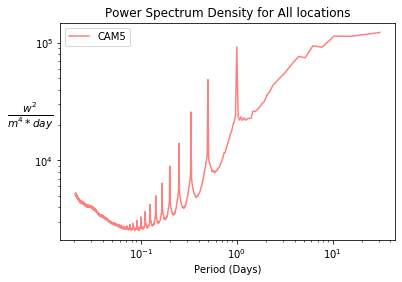

In [43]:
print(target_collector.shape)
lat_weighted_targs = np.nansum(target_collector[:,:,:,:]*weights[None,None,:,None], axis = 2)/np.sum(weights[:]) 
print(lat_weighted_targs.shape)
pressure_weighted_target_output = np.nansum(lat_weighted_targs * dp[None,:,None], axis = 1)/np.sum(dp) 
target_avg = np.nansum(pressure_weighted_target_output, axis = 1)
title = 'All locations'
np.save("/fast/gmooers/RG_Paper_Data/Weighted_CAM_Spectra_Moisture.npy",target_avg)
#np.save("/fast/gmooers/RG_Paper_Data/CAM_Spectra_freqs_Moisture.npy", targ_freqs)
plotter(target_avg, targ_freqs, title)

# Apply land and ocean  masks

In [48]:
lat_list = np.linspace(-90.0, 90.0, 96)
lon_list = np.linspace(0.0, 357.5, 144)

ocean_trop_target = np.zeros(shape=(len(target_collector), z, len(lat_list), len(target_collector[0][0][0])))
ocean_trop_target[:,:,:,:] = np.nan

for i in range(len(ocean_trop_target[0][0][0])):
    lon = lon_list[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(ocean_trop_target[0][0])):
        lat = lat_list[j]
        if bm.is_land(lon, lat) == False:
            ocean_trop_target[:, :, j, i] = target_collector[:, :, j, i]

print('mask applied')

mask applied


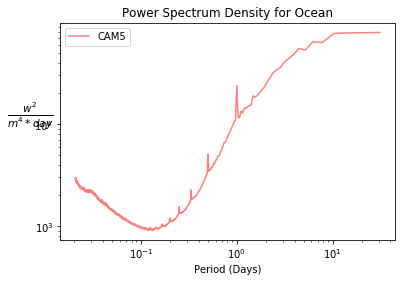

In [49]:
lat_weighted_targs = np.nansum(ocean_trop_target[:,:,:,:]*weights[None,None,:,None], axis = 2)/np.sum(weights[:]) 
pressure_weighted_target_output = np.nansum(lat_weighted_targs * dp[None,:,None], axis = 1)/np.sum(dp) 
target_avg = np.nansum(pressure_weighted_target_output, axis = 1)
title = 'Ocean'
np.save("/fast/gmooers/RG_Paper_Data/Weighted_CAM_Spectra_Moisture_Ocean.npy",target_avg)
#np.save("/fast/gmooers/RG_Paper_Data/CAM_Spectra_freqs_Moisture.npy", targ_freqs)
plotter(target_avg, targ_freqs, title)

In [50]:
land_trop_target = np.zeros(shape=(len(target_collector), z, len(lat_list), len(target_collector[0][0][0])))
land_trop_target[:,:,:,:] = np.nan

for i in range(len(land_trop_target[0][0][0])):
    lon = lon_list[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(land_trop_target[0][0])):
        lat = lat_list[j]
        if bm.is_land(lon, lat) == True:
            land_trop_target[:, :, j, i] = target_collector[:, :, j, i]

print('mask applied')

mask applied


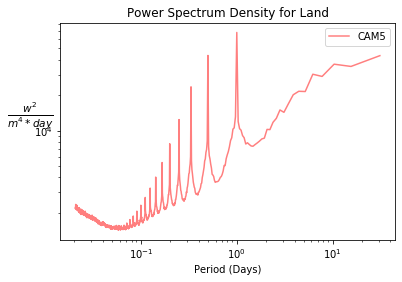

In [51]:
lat_weighted_targs = np.nansum(land_trop_target[:,:,:,:]*weights[None,None,:,None], axis = 2)/np.sum(weights[:]) 
pressure_weighted_target_output = np.nansum(lat_weighted_targs * dp[None,:,None], axis = 1)/np.sum(dp) 
target_avg = np.nansum(pressure_weighted_target_output, axis = 1)
title = 'Land'
np.save("/fast/gmooers/RG_Paper_Data/Weighted_CAM_Spectra_Moisture_Land.npy",target_avg)
#np.save("/fast/gmooers/RG_Paper_Data/CAM_Spectra_freqs_Moisture_Land.npy", targ_freqs)
plotter(target_avg, targ_freqs, title)